In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

# Base de dados

In [2]:
df = pd.read_csv('dengue_sinan.csv')

/tmp/ipykernel_18860/3503175965.py:1: DtypeWarning: Columns (30,31,53,54,55,59,61,63,65,71,83,89,100,116,131,137) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dengue_sinan.csv')


In [3]:
display(df)

,NU_NOTIFIC,TP_NOT,ID_AGRAVO,DT_NOTIFIC,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,...,DT_TRANSRM,DT_TRANSRS,DT_TRANSSE,NU_LOTE_V,NU_LOTE_H,CS_FLXRET,FLXRECEBI,IDENT_MICR,MIGRADO_W,ID_CNS_SUS_HASHED
0,158,2,A90,2016-03-05,201609,2016,29,292210,1381.0,2498731.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...
1,298,2,A90,2016-02-15,201607,2016,29,293290,1385.0,3280969.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,ebc774c2fc9be73f8d403772dc14539dbe6e448e117f62...
2,5082,2,A90,2016-03-25,201612,2016,29,293250,1385.0,2800527.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,4.0,NaN,e0f037bc45eeea73df919230256055724a0bc45b990d62...
3,111262,2,A90,2016-03-24,201612,2016,29,291360,1385.0,2706628.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...
4,166,2,A90,2016-03-13,201611,2016,29,292210,1381.0,2498731.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,595d3ab2cc2bfc76ee1e9ef090ac6abf0e7b64aee90e92...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620206,7061,2,A90,2024-02-21,202408,2024,29,292300,1388.0,2506254.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,4ca7df06d628b3ec9fcf8f4a3a8b11661f5e98b8e54b34...
620207,1257,2,A90,2024-03-04,202410,2024,29,291980,1398.0,7175973.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,5152560db10a8bc76f1490909a74620605b6f3b512e8d7...
620208,372024,2,A90,2024-01-26,202404,2024,29,292303,1381.0,6540007.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,d7c7bebe87009f4f9e4a606f6fe2ddc83a67ea3c48ada8...
620209,128,2,A90,2024-02-19,202408,2024,29,291400,1381.0,2824558.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,4.0,NaN,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...


In [4]:
# VEndo a distribuição da coluna alvo
df['CLASSI_FIN'].value_counts()

10.0    215033
8.0     169106
5.0     158336
11.0      5656
1.0       1201
12.0       463
2.0          2
Name: CLASSI_FIN, dtype: int64

In [5]:
# Trocando para dengue / não-dengue
df.dropna(subset=['CLASSI_FIN'], inplace=True)
df['CLASSI_FIN'] = df['CLASSI_FIN'].apply(lambda x:1 if x == (10.0 or 11.0 or 12.0) else 0)

In [6]:
# Conferindo mais uma vez
df['CLASSI_FIN'].value_counts()

0    334764
1    215033
Name: CLASSI_FIN, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['CLASSI_FIN'], axis=1)
y = df['CLASSI_FIN']

X_val, X_teste, y_val, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_val, y_val, test_size=0.25, random_state=42)

# 1. Pré-processamento

## REMOÇÃO DE COLUNAS COM MUITOS VALORES AUSENTES

In [8]:
# Contagem de valores nulos / células ausentes
pd.set_option('display.max_rows', None)
total_linhas = X_train.shape[0]
valores_nulos_por_coluna = X_train.isnull().sum()
porcentagem_nulos_por_coluna = (valores_nulos_por_coluna / total_linhas) * 100
print(porcentagem_nulos_por_coluna.sort_values())
quantidade_acima_70 = (porcentagem_nulos_por_coluna > 70).sum()
print("----------------------------------------------")
print("Quantidade de valores acima de 70%:", quantidade_acima_70)
print("Porcentagem para exclusão:", round(((quantidade_acima_70/148)*100)),"%")

colunas_nulas = porcentagem_nulos_por_coluna[porcentagem_nulos_por_coluna > 70].index.tolist()

NU_NOTIFIC             0.000000
ID_PAIS                0.000000
ID_MN_RESI             0.000000
NU_IDADE_N             0.000000
SEM_PRI                0.000000
ID_MUNICIP             0.000000
ID_CNS_SUS_HASHED      0.000000
NU_ANO                 0.000000
TP_NOT                 0.000000
ID_AGRAVO              0.000000
DT_NOTIFIC             0.000000
SG_UF_NOT              0.000000
SEM_NOT                0.000000
DT_SIN_PRI             0.000303
CS_FLXRET              0.000606
ID_RG_RESI             0.003941
SG_UF                  0.008488
CS_SEXO                0.008791
CS_GESTANT             0.025767
ID_REGIONA             0.041531
ID_UNIDADE             0.086699
DT_DIGITA              0.818790
TP_SISTEMA             0.819093
IDENT_MICR             0.824853
CS_RACA                1.545121
DT_ENCERRA             2.941096
CS_ZONA                8.859969
DT_INVEST             10.157725
NM_BAIRRO             11.643128
ACIDO_PEPT            12.901779
AUTO_IMUNE            12.901779
HIPERTEN

In [9]:
# Contagem de valores nulos / células ausentes
pd.set_option('display.max_rows', None)
total_linhas = X_teste.shape[0]
valores_nulos_por_coluna = X_teste.isnull().sum()
porcentagem_nulos_por_coluna = (valores_nulos_por_coluna / total_linhas) * 100
print(porcentagem_nulos_por_coluna.sort_values())
quantidade_acima_70 = (porcentagem_nulos_por_coluna > 70).sum()
print("----------------------------------------------")
print("Quantidade de valores acima de 70%:", quantidade_acima_70)
print("Porcentagem para exclusão:", round(((quantidade_acima_70/148)*100)),"%")

colunas_nulas = porcentagem_nulos_por_coluna[porcentagem_nulos_por_coluna > 70].index.tolist()

NU_NOTIFIC             0.000000
CS_FLXRET              0.000000
ID_PAIS                0.000000
ID_MN_RESI             0.000000
NU_IDADE_N             0.000000
SEM_PRI                0.000000
DT_SIN_PRI             0.000000
ID_CNS_SUS_HASHED      0.000000
SG_UF_NOT              0.000000
NU_ANO                 0.000000
ID_AGRAVO              0.000000
SEM_NOT                0.000000
ID_MUNICIP             0.000000
DT_NOTIFIC             0.000000
TP_NOT                 0.000000
ID_RG_RESI             0.005457
CS_SEXO                0.010004
SG_UF                  0.010004
CS_GESTANT             0.016370
ID_REGIONA             0.046381
ID_UNIDADE             0.071844
TP_SISTEMA             0.792106
DT_DIGITA              0.792106
IDENT_MICR             0.795744
CS_RACA                1.584212
DT_ENCERRA             2.924700
CS_ZONA                8.897781
DT_INVEST             10.092761
NM_BAIRRO             11.601491
LEUCOPENIA            12.817388
LACO                  12.817388
DOR_RETR

In [10]:
# Contagem de valores nulos / células ausentes
pd.set_option('display.max_rows', None)
total_linhas = X_cv.shape[0]
valores_nulos_por_coluna = X_cv.isnull().sum()
porcentagem_nulos_por_coluna = (valores_nulos_por_coluna / total_linhas) * 100
print(porcentagem_nulos_por_coluna.sort_values())
quantidade_acima_70 = (porcentagem_nulos_por_coluna > 70).sum()
print("----------------------------------------------")
print("Quantidade de valores acima de 70%:", quantidade_acima_70)
print("Porcentagem para exclusão:", round(((quantidade_acima_70/148)*100)),"%")

colunas_nulas = porcentagem_nulos_por_coluna[porcentagem_nulos_por_coluna > 70].index.tolist()

NU_NOTIFIC             0.000000
CS_FLXRET              0.000000
ID_MN_RESI             0.000000
NU_IDADE_N             0.000000
SEM_PRI                0.000000
DT_SIN_PRI             0.000000
ID_MUNICIP             0.000000
ID_CNS_SUS_HASHED      0.000000
NU_ANO                 0.000000
SEM_NOT                0.000000
DT_NOTIFIC             0.000000
SG_UF_NOT              0.000000
ID_AGRAVO              0.000000
TP_NOT                 0.000000
ID_PAIS                0.000909
ID_RG_RESI             0.008185
CS_SEXO                0.011822
SG_UF                  0.011822
CS_GESTANT             0.021826
ID_REGIONA             0.031830
ID_UNIDADE             0.078210
TP_SISTEMA             0.797563
DT_DIGITA              0.797563
IDENT_MICR             0.805748
CS_RACA                1.535104
DT_ENCERRA             2.972899
CS_ZONA                9.016006
DT_INVEST             10.058203
NM_BAIRRO             11.479629
LEUCOPENIA            12.795562
LACO                  12.795562
DOR_RETR

In [11]:
# Contagem de colunas com 1 tipo de valor, pois não impactam no final
colunas_unique = []
for column in X_train.columns:
    if X_train[column].nunique() == 1:
        colunas_unique.append(column)
        print(df[column].value_counts())
        print("\n------------------------")

A90    549797
Name: ID_AGRAVO, dtype: int64

------------------------
29.0    549745
Name: SG_UF, dtype: int64

------------------------
291920.0    1
81.0        1
Name: ID_LOGRADO, dtype: int64

------------------------
1.0    549796
Name: ID_PAIS, dtype: int64

------------------------
1.0      150350
156.0         1
31.0          1
Name: COPAISINF, dtype: int64

------------------------
2.0    2
Name: GENGIVO, dtype: int64

------------------------
2.0    2
Name: METRO, dtype: int64

------------------------
2.0    2
Name: SANGRAM, dtype: int64

------------------------
8.0    1
5.0    1
Name: COMPLICA, dtype: int64

------------------------
0.0    2
Name: NU_LOTE_I, dtype: int64

------------------------
2.0    545347
Name: TP_SISTEMA, dtype: int64

------------------------
1.0    114
Name: NDUPLIC_N, dtype: int64

------------------------
0.0    2
Name: NU_LOTE_V, dtype: int64

------------------------


In [12]:
# Pegando todas as colunas que iremos retirar, e mesclando elass
# Iremos remover as colunas com > 70% ausentes (pois não temos como inputar) e as colunas com apenas 1 valor distinto (pois não impactam no final)
colunas_a_dropar = (colunas_nulas) + (colunas_unique)
print(colunas_a_dropar)
len(colunas_a_dropar)

['SOUNDEX', 'ID_DISTRIT', 'ID_LOGRADO', 'ID_GEO1', 'ID_GEO2', 'NM_REFEREN', 'ID_OCUPA_N', 'DT_CHIK_S1', 'DT_CHIK_S2', 'DT_PRNT', 'RES_CHIKS1', 'RES_CHIKS2', 'RESUL_PRNT', 'DT_SORO', 'DT_NS1', 'DT_VIRAL', 'RESUL_VI_N', 'DT_PCR', 'SOROTIPO', 'HISTOPA_N', 'IMUNOH_N', 'DT_INTERNA', 'UF', 'MUNICIPIO', 'HOSPITAL', 'DDD_HOSP', 'TEL_HOSP', 'COUFINF', 'COPAISINF', 'COMUNINF', 'CODISINF', 'CO_BAINF', 'NOBAIINF', 'DOENCA_TRA', 'CLINC_CHIK', 'DT_OBITO', 'ALRM_HIPOT', 'ALRM_PLAQ', 'ALRM_VOM', 'ALRM_SANG', 'ALRM_HEMAT', 'ALRM_ABDOM', 'ALRM_LETAR', 'ALRM_HEPAT', 'ALRM_LIQ', 'DT_ALRM', 'GRAV_PULSO', 'GRAV_CONV', 'GRAV_ENCH', 'GRAV_INSUF', 'GRAV_TAQUI', 'GRAV_EXTRE', 'GRAV_HIPOT', 'GRAV_HEMAT', 'GRAV_MELEN', 'GRAV_METRO', 'GRAV_SANG', 'GRAV_AST', 'GRAV_MIOC', 'GRAV_CONSC', 'GRAV_ORGAO', 'DT_GRAV', 'MANI_HEMOR', 'EPISTAXE', 'GENGIVO', 'METRO', 'PETEQUIAS', 'HEMATURA', 'SANGRAM', 'LACO_N', 'PLASMATICO', 'EVIDENCIA', 'PLAQ_MENOR', 'CON_FHD', 'COMPLICA', 'NU_LOTE_I', 'DS_OBS', 'NDUPLIC_N', 'DT_TRANSUS', 'D

101

In [13]:
# FInalmente, dropando as colunas
X_train.drop(colunas_a_dropar, axis=1, inplace=True)
X_teste.drop(colunas_a_dropar, axis=1, inplace=True)
X_cv.drop(colunas_a_dropar, axis=1, inplace=True)

In [14]:
# COmo ficamos, finalmente?
X_train.shape
X_teste.shape
X_cv.shape

(109960, 55)

## GRÁFICOS (MATRIZ DE CORRELAÇÃO/COVARIÂNCIA, HISTOGRAMAS / BOXPLOTS)

In [15]:
# Observando os tipos de colunas
print("Categóricas: ")
print(X_train.select_dtypes(include='object').columns.tolist())
print("\nNuméricas: ")
print(X_train.select_dtypes(include='number').columns.tolist())

Categóricas: 
['DT_NOTIFIC', 'DT_SIN_PRI', 'CS_SEXO', 'NM_BAIRRO', 'DT_INVEST', 'DT_ENCERRA', 'DT_DIGITA', 'ID_CNS_SUS_HASHED']

Numéricas: 
['NU_NOTIFIC', 'TP_NOT', 'SEM_NOT', 'NU_ANO', 'SG_UF_NOT', 'ID_MUNICIP', 'ID_REGIONA', 'ID_UNIDADE', 'SEM_PRI', 'NU_IDADE_N', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'ID_MN_RESI', 'ID_RG_RESI', 'ID_BAIRRO', 'CS_ZONA', 'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO', 'DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT', 'AUTO_IMUNE', 'RESUL_SORO', 'RESUL_NS1', 'RESUL_PCR_', 'HOSPITALIZ', 'TPAUTOCTO', 'CRITERIO', 'EVOLUCAO', 'CS_FLXRET', 'IDENT_MICR']


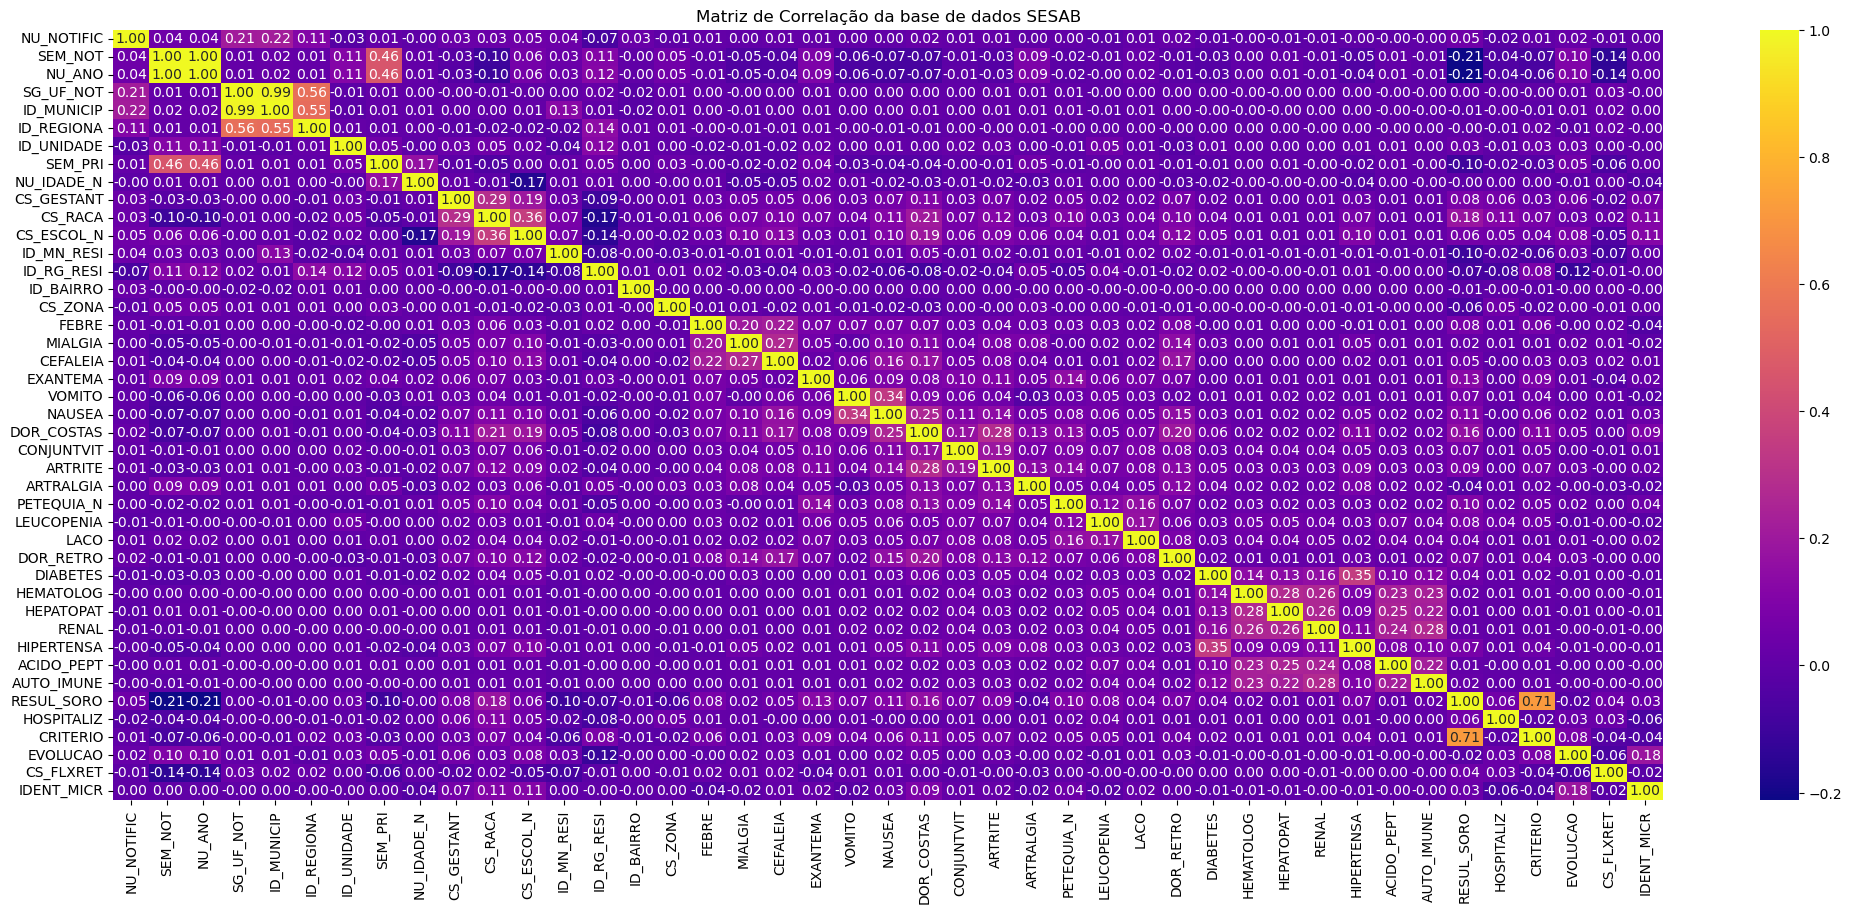

In [16]:
# Plotando matrizes
colunas_num = ['NU_NOTIFIC', 'SEM_NOT', 'NU_ANO', 'SG_UF_NOT', 'ID_MUNICIP', 'ID_REGIONA',
               'ID_UNIDADE', 'SEM_PRI', 'NU_IDADE_N', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'ID_MN_RESI',
               'ID_RG_RESI', 'ID_BAIRRO', 'CS_ZONA', 'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA',
               'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO', 'DIABETES', 
               'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT', 'AUTO_IMUNE', 'RESUL_SORO', 'HOSPITALIZ',
               'CRITERIO', 'EVOLUCAO', 'CS_FLXRET', 'IDENT_MICR']
df_analisenum = X_train[colunas_num]
matriz_correlacao = df_analisenum.corr()

plt.figure(figsize=(25, 10))
sns.heatmap(matriz_correlacao, annot=True, cmap='plasma', fmt=".2f")
plt.title('Matriz de Correlação da base de dados SESAB')
plt.show()

In [17]:
""" #Plotando boxplots
for coluna in df_analisenum:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=X_train[coluna])
    plt.title('Boxplot para {}'.format(coluna))
    plt.xlabel('Valores')
    plt.ylabel('{}'.format(coluna))
    plt.show() """

" #Plotando boxplots\nfor coluna in df_analisenum:\n    plt.figure(figsize=(8, 6))\n    sns.boxplot(data=X_train[coluna])\n    plt.title('Boxplot para {}'.format(coluna))\n    plt.xlabel('Valores')\n    plt.ylabel('{}'.format(coluna))\n    plt.show() "

## CODIFICAÇÃO/ENCODING

In [18]:
pd.set_option('display.max_rows', 50)
colunas_cat = ['DT_NOTIFIC', 'DT_SIN_PRI', 'CS_SEXO', 'NM_BAIRRO', 'DT_INVEST', 'DT_ENCERRA', 'DT_DIGITA', 'ID_CNS_SUS_HASHED']
for coluna in colunas_cat:
    print(X_train[coluna].value_counts())
    print()

2024-02-27    1343
2024-02-28    1324
2024-02-26    1306
2024-03-05    1296
2024-02-29    1246
              ... 
2016-07-03       1
2017-09-17       1
2017-09-23       1
2018-09-23       1
2021-09-19       1
Name: DT_NOTIFIC, Length: 3007, dtype: int64

2024-02-26    1195
2024-02-25    1011
2024-03-04    1011
2024-02-27     986
2024-02-28     978
              ... 
1992-05-06       1
1960-04-13       1
1981-09-11       1
1985-07-19       1
1971-03-02       1
Name: DT_SIN_PRI, Length: 4405, dtype: int64

F    186094
M    143004
I       750
Name: CS_SEXO, dtype: int64

CENTRO                  35562
ZONA RURAL              11529
SANTO ANTONIO            2925
SANTA CRUZ               1990
SANTA LUZIA              1501
                        ...  
MALHDINHA DE FORA           1
RUA EDUARDO SILVA           1
DIOGENES SAMPAIO            1
PRIMAVERA LESTE             1
RUA JAOQUIM CARVALHO        1
Name: NM_BAIRRO, Length: 13646, dtype: int64

2024-02-26    1369
2024-02-28    1336
2024-02-27 

### Podemos dropar 'ID_CNS_SUS_HASHED', pois não influencia no algoritmo, é apenas uma chave HASH.
### O dicionário informa que 'DT_ENCERRA' é a data de encerramento de caso. Podemos considerar excluí-la também, tendo em vista que a predição é se HÁ ou NÃO dengue, e essa coluna apenas informa o final do caso. Não temos informação sobre 'DT_DIGITA', 'DT_NOTIFIC', 'DT_SIN_PRI'
### A coluna 'CS_SEXO' pode ser codificada como ONE-HOT encoder, pois só tem 3 valores distintos.
### A coluna 'NM_BAIRRO' tem 19834 valores diferentes.

In [19]:
colunas_drop = ['DT_NOTIFIC', 'DT_SIN_PRI', 'DT_INVEST', 'DT_ENCERRA', 'DT_DIGITA', 'ID_CNS_SUS_HASHED', 'TP_NOT']
X_train.drop(colunas_drop, axis=1, inplace=True)
X_teste.drop(colunas_drop, axis=1, inplace=True)
X_cv.drop(colunas_drop, axis=1, inplace=True)

In [20]:
from sklearn.preprocessing import OneHotEncoder

col_to_encode = 'CS_SEXO'
encoder = OneHotEncoder(sparse_output=False, drop=None)  #drop='first' para evitar a dummy variable trap
encoded_data = encoder.fit_transform(X_train[[col_to_encode]])
new_columns = encoder.get_feature_names_out([col_to_encode])
X_train[new_columns] = encoded_data
X_train = X_train.drop([col_to_encode], axis=1)

In [21]:
from sklearn.preprocessing import OneHotEncoder

col_to_encode = 'CS_SEXO'
encoder = OneHotEncoder(sparse_output=False, drop=None)  #drop='first' para evitar a dummy variable trap
encoded_data = encoder.fit_transform(X_teste[[col_to_encode]])
new_columns = encoder.get_feature_names_out([col_to_encode])
X_teste[new_columns] = encoded_data
X_teste = X_teste.drop([col_to_encode], axis=1)

In [22]:
from sklearn.preprocessing import OneHotEncoder

col_to_encode = 'CS_SEXO'
encoder = OneHotEncoder(sparse_output=False, drop=None)  #drop='first' para evitar a dummy variable trap
encoded_data = encoder.fit_transform(X_cv[[col_to_encode]])
new_columns = encoder.get_feature_names_out([col_to_encode])
X_cv[new_columns] = encoded_data
X_cv = X_cv.drop([col_to_encode], axis=1)

In [23]:
# Conferindo se deu certo
X_train.iloc[:, -4:]
X_teste.iloc[:, -4:]
X_cv.iloc[:, -4:]

,CS_SEXO_F,CS_SEXO_I,CS_SEXO_M,CS_SEXO_nan
162479,1.0,0.0,0.0,0.0
389055,0.0,0.0,1.0,0.0
296762,0.0,0.0,1.0,0.0
160067,1.0,0.0,0.0,0.0
332433,1.0,0.0,0.0,0.0
...,...,...,...,...
344343,0.0,0.0,1.0,0.0
496952,1.0,0.0,0.0,0.0
229009,1.0,0.0,0.0,0.0
89951,1.0,0.0,0.0,0.0


## INPUTAÇÃO DE VALORES

In [24]:
# Contagem de valores nulos / células ausentes
pd.set_option('display.max_rows', None)
total_linhas = X_train.shape[0]
valores_nulos_por_coluna = X_train.isnull().sum()
porcentagem_nulos_por_coluna = (valores_nulos_por_coluna / total_linhas) * 100
print(porcentagem_nulos_por_coluna.sort_values())
quantidade_acima_70 = (porcentagem_nulos_por_coluna > 70).sum()
print("----------------------------------------------")

NU_NOTIFIC      0.000000
CS_SEXO_I       0.000000
CS_SEXO_F       0.000000
CS_SEXO_M       0.000000
ID_MN_RESI      0.000000
NU_IDADE_N      0.000000
SEM_PRI         0.000000
CS_SEXO_nan     0.000000
SG_UF_NOT       0.000000
SEM_NOT         0.000000
ID_MUNICIP      0.000000
NU_ANO          0.000000
CS_FLXRET       0.000606
ID_RG_RESI      0.003941
CS_GESTANT      0.025767
ID_REGIONA      0.041531
ID_UNIDADE      0.086699
IDENT_MICR      0.824853
CS_RACA         1.545121
CS_ZONA         8.859969
NM_BAIRRO      11.643128
DOR_RETRO      12.901779
AUTO_IMUNE     12.901779
ACIDO_PEPT     12.901779
HIPERTENSA     12.901779
RENAL          12.901779
HEPATOPAT      12.901779
HEMATOLOG      12.901779
DIABETES       12.901779
LACO           12.901779
PETEQUIA_N     12.901779
FEBRE          12.901779
MIALGIA        12.901779
LEUCOPENIA     12.901779
CEFALEIA       12.901779
EXANTEMA       12.901779
ARTRITE        12.901779
NAUSEA         12.901779
DOR_COSTAS     12.901779
CONJUNTVIT     12.901779


### Antes de inputar as colunas, vamos dar uma olhada nas últimas com maior quantidade de valores ausentes.
### Comecemos pelas últimas, de 23% para cima.

In [25]:
# Não for informado oq seria essa coluna no dicionário e pelos valores, também não conseguimos desvendar
X_train['CS_ESCOL_N'].value_counts()

9.0     121848
10.0     32785
6.0      30862
3.0      16627
5.0      12868
1.0      12234
4.0       8186
8.0       6982
2.0       6297
7.0       3116
0.0       2375
Name: CS_ESCOL_N, dtype: int64

In [26]:
# Temos 2 colunas 'NM_BAIRRO' e 'ID_BAIRRO' que não batem os valores
X_train['ID_BAIRRO'].value_counts()

6.0           3516
1.0           2899
2.0           2741
7.0           2615
10.0          2556
8.0           2508
17.0          2311
3.0           2255
14.0          2224
19.0          2151
5.0           1692
4.0           1641
105.0         1629
107.0         1611
18.0          1586
20.0          1503
192.0         1483
32.0          1405
85.0          1381
23.0          1274
685.0         1266
148.0         1249
115.0         1220
106.0         1210
244.0         1195
79.0          1164
31.0          1160
84.0          1136
123.0         1114
15.0          1100
12.0          1092
74.0          1079
116.0         1056
183.0         1053
147.0         1052
441.0         1047
67.0          1016
9.0           1000
179.0          996
100.0          976
88.0           967
75.0           959
104.0          953
252.0          947
58.0           939
197.0          934
16.0           931
64.0           927
650.0          924
24.0           924
13.0           911
60.0           893
610.0       

In [27]:
# Podemos dropar a coluna 'EVOLUCAO' pois estamos tentando predizer 'Este indivíduo foi diagnosticado com dengue com base nos dados disponíveis?'
# Pode ser uma variável futura muito importante para prever a evolução do caso, de leve para grave.

# Da mesma forma 'HOSPITALIZ'.

# Vamos dropar a coluna 'NM_BAIRRO', pois é uma coluna categórica (nos poupa o trabalho do encoder, além de ter que analisar casos em que há digitação errada.)
colunas_drop2 = ['CS_ESCOL_N', 'NM_BAIRRO', 'EVOLUCAO', 'HOSPITALIZ', 'NU_NOTIFIC']
X_train.drop(colunas_drop2, axis=1, inplace=True)
X_teste.drop(colunas_drop2, axis=1, inplace=True)
X_cv.drop(colunas_drop2, axis=1, inplace=True)

In [28]:
# 'RESUL_SORO' é importante, pois é associado ao que queremos saber, se há dengue ou não.
# Porém, tem uma quantidade muito grande de valores ausentes. Como temos um dataset muito grande, podemos pegar a quantidade que temos para simular um dataset.
X_train = X_train.dropna(subset=['RESUL_SORO'])
X_teste = X_teste.dropna(subset=['RESUL_SORO'])
X_cv = X_cv.dropna(subset=['RESUL_SORO'])

In [29]:
# Contagem de valores nulos / células ausentes
pd.set_option('display.max_rows', None)
total_linhas = X_train.shape[0]
valores_nulos_por_coluna = X_train.isnull().sum()
porcentagem_nulos_por_coluna2 = (valores_nulos_por_coluna / total_linhas) * 100
print(porcentagem_nulos_por_coluna2.sort_values())
print("----------------------------------------------")
colunas_nulas_2 = porcentagem_nulos_por_coluna2.index.tolist()

SEM_NOT         0.000000
CS_SEXO_I       0.000000
CS_SEXO_F       0.000000
CS_FLXRET       0.000000
RESUL_SORO      0.000000
CS_SEXO_M       0.000000
ID_MN_RESI      0.000000
CS_SEXO_nan     0.000000
NU_IDADE_N      0.000000
ID_MUNICIP      0.000000
SEM_PRI         0.000000
NU_ANO          0.000000
SG_UF_NOT       0.000000
ID_RG_RESI      0.007797
CS_GESTANT      0.029063
ID_REGIONA      0.040405
ID_UNIDADE      0.143188
IDENT_MICR      0.913002
CS_RACA         1.225607
DOR_RETRO       3.201888
ACIDO_PEPT      3.201888
HIPERTENSA      3.201888
RENAL           3.201888
HEPATOPAT       3.201888
HEMATOLOG       3.201888
DIABETES        3.201888
AUTO_IMUNE      3.201888
LACO            3.201888
PETEQUIA_N      3.201888
FEBRE           3.201888
MIALGIA         3.201888
LEUCOPENIA      3.201888
CEFALEIA        3.201888
EXANTEMA        3.201888
ARTRITE         3.201888
NAUSEA          3.201888
DOR_COSTAS      3.201888
CONJUNTVIT      3.201888
ARTRALGIA       3.201888
VOMITO          3.201888


In [30]:
print(colunas_nulas_2)

['SEM_NOT', 'NU_ANO', 'SG_UF_NOT', 'ID_MUNICIP', 'ID_REGIONA', 'ID_UNIDADE', 'SEM_PRI', 'NU_IDADE_N', 'CS_GESTANT', 'CS_RACA', 'ID_MN_RESI', 'ID_RG_RESI', 'ID_BAIRRO', 'CS_ZONA', 'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO', 'DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT', 'AUTO_IMUNE', 'RESUL_SORO', 'RESUL_NS1', 'RESUL_PCR_', 'TPAUTOCTO', 'CRITERIO', 'CS_FLXRET', 'IDENT_MICR', 'CS_SEXO_F', 'CS_SEXO_I', 'CS_SEXO_M', 'CS_SEXO_nan']


In [31]:
X_train.shape

(141073, 46)

In [32]:
# # Utilizando grid search para procurar melhores parâmetros para o inputador
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, r2_score

# param = {
#     'max_iter': [5, 10, 20],
#     'tol': [0.001, 0.01, 0.1]
# }

# grid_search = GridSearchCV(imputer, param, cv=5, scoring=make_scorer(r2_score))

# grid_search.fit(df)
# print(grid_search.best_params_)

In [33]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer()
X_train[colunas_nulas_2] = imputer.fit_transform(X_train[colunas_nulas_2])

In [34]:
X_teste[colunas_nulas_2] = imputer.transform(X_teste[colunas_nulas_2])

In [35]:
X_cv[colunas_nulas_2] = imputer.transform(X_cv[colunas_nulas_2])

In [36]:
# Contagem de valores nulos / células ausentes
pd.set_option('display.max_rows', None)
total_linhas = X_train.shape[0]
valores_nulos_por_coluna = X_train.isnull().sum()
porcentagem_nulos_por_coluna = (valores_nulos_por_coluna / total_linhas) * 100
print(porcentagem_nulos_por_coluna.sort_values())
print("----------------------------------------------")

SEM_NOT        0.0
LEUCOPENIA     0.0
LACO           0.0
DOR_RETRO      0.0
DIABETES       0.0
HEMATOLOG      0.0
HEPATOPAT      0.0
RENAL          0.0
HIPERTENSA     0.0
ACIDO_PEPT     0.0
AUTO_IMUNE     0.0
RESUL_SORO     0.0
RESUL_NS1      0.0
RESUL_PCR_     0.0
TPAUTOCTO      0.0
CRITERIO       0.0
CS_FLXRET      0.0
IDENT_MICR     0.0
CS_SEXO_F      0.0
CS_SEXO_I      0.0
PETEQUIA_N     0.0
ARTRALGIA      0.0
ARTRITE        0.0
CONJUNTVIT     0.0
NU_ANO         0.0
SG_UF_NOT      0.0
ID_MUNICIP     0.0
ID_REGIONA     0.0
ID_UNIDADE     0.0
SEM_PRI        0.0
NU_IDADE_N     0.0
CS_GESTANT     0.0
CS_RACA        0.0
CS_SEXO_M      0.0
ID_MN_RESI     0.0
ID_BAIRRO      0.0
CS_ZONA        0.0
FEBRE          0.0
MIALGIA        0.0
CEFALEIA       0.0
EXANTEMA       0.0
VOMITO         0.0
NAUSEA         0.0
DOR_COSTAS     0.0
ID_RG_RESI     0.0
CS_SEXO_nan    0.0
dtype: float64
----------------------------------------------


## NORMALIZAÇÃO/PADRONIZAÇÃO

In [37]:
# Instanciando padronizador
from sklearn.preprocessing import StandardScaler

# X_train_copy = X_train.copy()
scaler = StandardScaler()
scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train)

In [38]:
X_teste[X_teste.columns] = scaler.transform(X_teste)

In [39]:
X_cv[X_cv.columns] = scaler.transform(X_cv)

In [40]:
# MOstrando dataframe
pd.set_option('display.max_rows', 10)
display(X_train)

,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,SEM_PRI,NU_IDADE_N,CS_GESTANT,CS_RACA,...,RESUL_NS1,RESUL_PCR_,TPAUTOCTO,CRITERIO,CS_FLXRET,IDENT_MICR,CS_SEXO_F,CS_SEXO_I,CS_SEXO_M,CS_SEXO_nan
114373,-0.511573,-0.481698,-0.034513,0.123582,-0.147499,-0.471805,-0.210359,0.104692,-0.020815,-0.433312,...,0.474637,0.234499,2.101330,0.941416,-1.091571,-0.283017,0.866040,-0.038795,-0.863160,-0.011296
198619,-0.083039,-0.114447,-0.034513,0.027034,0.106565,-0.665309,-0.014624,0.192723,-0.837009,-0.433312,...,0.474637,0.234499,-0.413440,0.941416,0.916111,-0.283017,0.866040,-0.038795,-0.863160,-0.011296
501836,1.330754,1.354554,-0.034513,-0.044975,0.106565,0.969055,0.631134,0.034266,-0.020815,-0.433312,...,2.842817,1.577782,-0.535586,2.847823,-1.091571,-0.283017,0.866040,-0.038795,-0.863160,-0.011296
322889,0.213637,0.252803,-0.034513,-0.234452,0.181289,0.927377,0.120885,0.144306,-0.020815,1.405370,...,0.474637,0.234499,-0.535586,0.941416,0.916111,-0.283017,0.866040,-0.038795,-0.863160,-0.011296
262059,-0.126992,-0.114447,-0.034513,-0.204951,-0.087719,-0.720231,-0.036372,0.205928,-0.020815,-0.433312,...,0.249985,-0.316470,0.049943,-0.964990,-1.091571,-0.283017,-1.154681,-0.038795,1.158533,-0.011296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55211,-1.592062,-1.583449,-0.034513,-0.078901,-0.087719,-0.666454,-0.703879,0.091487,-0.020815,1.405370,...,0.474637,0.234499,-0.535586,0.941416,0.916111,-0.283017,-1.154681,-0.038795,1.158533,-0.011296
381230,0.620194,0.620053,-0.034513,-0.014536,-0.147499,-0.678566,0.304909,0.192723,-0.837009,-0.433312,...,-0.243404,-0.447947,-0.535586,-0.964990,0.916111,-0.283017,0.866040,-0.038795,-0.863160,-0.011296
340359,0.195324,0.252803,-0.034513,0.090058,-0.162444,-1.650498,0.112520,0.126699,-0.020815,-0.433312,...,0.474637,0.234499,4.738246,0.941416,-1.091571,-0.283017,-1.154681,-0.038795,1.158533,-0.011296
28684,-1.581074,-1.583449,-0.034513,0.110173,0.181289,-0.071511,-0.698860,0.109093,-0.020815,-1.168785,...,-2.393159,0.234499,0.488891,-0.964990,0.916111,-0.283017,-1.154681,-0.038795,1.158533,-0.011296


In [41]:
# Vendo dataframe finalizado após pré-processamento
X_train.shape

(141073, 46)

In [42]:
X_cv.shape

(47198, 46)

In [43]:
X_teste.shape

(46993, 46)

In [44]:
y_train.value_counts()

0    200828
1    129049
Name: CLASSI_FIN, dtype: int64

In [45]:
y_cv.value_counts()

0    66997
1    42963
Name: CLASSI_FIN, dtype: int64

In [46]:
y_teste.value_counts()

0    66939
1    43021
Name: CLASSI_FIN, dtype: int64

# 2. Algoritmos

In [47]:
# COmbinando os índices do target com os features
indices_presentes = X_train.index
y_train = y_train.loc[indices_presentes]

indices_teste_teste = X_teste.index
y_teste = y_teste.loc[indices_teste_teste]

indices_presentes_cv = X_cv.index
y_cv = y_cv.loc[indices_presentes_cv]

In [48]:
# K-Nearest Neighbors (KNN)
# Número de Vizinhos (K): Comece com K=5, podendo ser ajustado por meio de validação cruzada.
# Métrica de Distância: Euclidiana.
# Peso das amostras: Uniforme.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

parametros_knn = {'n_neighbors': range(1, 21)}

knn = KNeighborsClassifier(metric='euclidean', weights='uniform')

grid_search = GridSearchCV(knn, parametros_knn, cv=5)
grid_search.fit(X_cv, y_cv)
print('Melhor numero de vizinhos:', grid_search.best_params_)
print('*********************************************')

knn_final = KNeighborsClassifier(n_neighbors=13, metric='euclidean', weights='uniform')
knn_final.fit(X_train, y_train)

knn_pred = knn_final.predict(X_teste)
acurácia_knn = accuracy_score(y_teste, knn_pred)
p_knn = precision_score(y_teste, knn_pred, average='macro')
r_knn = recall_score(y_teste, knn_pred, average='macro')
f1_knn = f1_score(y_teste, knn_pred, average='macro')

print("Acurácia", acurácia_knn)
print("Precisão:", p_knn)
print("Recall:", r_knn)
print("F1-score:", f1_knn)

Melhor numero de vizinhos: {'n_neighbors': 13}
*********************************************
Acurácia 0.7633051731108889
Precisão: 0.7631606028158515
Recall: 0.7635905445144573
F1-score: 0.7631633397915136


In [49]:
# Árvore de Decisão
# Critério de Divisão: Entropia
# Profundidade Máxima: Sem limite inicial, ajustável com validação cruzada
# Número Mínimo de Amostras para Divisão de um Nó: 2.
# Número Mínimo de Amostras em um Nó Folha: 1

from sklearn import tree

parametros_clfArvore = {'max_depth': range(1, 21)}

clfArvore = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=2, min_samples_leaf=1)

grid_search = GridSearchCV(clfArvore, parametros_clfArvore, cv=5)
grid_search.fit(X_cv, y_cv)
print('Profundidade máxima com melhor desempenho:', grid_search.best_params_)
print('*********************************************')

clfArvore_final = tree.DecisionTreeClassifier(max_depth = 12, criterion='entropy', min_samples_split=2, min_samples_leaf=1)
clfArvore_final.fit(X_train, y_train)

clfArvore_pred = clfArvore_final.predict(X_teste)
acurácia_clfArvore = accuracy_score(y_teste, clfArvore_pred)
p_clfArvore = precision_score(y_teste, clfArvore_pred, average='macro')
r_clfArvore = recall_score(y_teste, clfArvore_pred, average='macro')
f1_clfArvore = f1_score(y_teste, clfArvore_pred, average='macro')

print("Acurácia", acurácia_clfArvore)
print("Precisão:", p_clfArvore)
print("Recall:", r_clfArvore)
print("F1-score:", f1_clfArvore)

Profundidade máxima com melhor desempenho: {'max_depth': 11}
*********************************************
Acurácia 0.9459493967186602
Precisão: 0.9462842956327182
Recall: 0.9454930395802866
F1-score: 0.9458140066742176


In [50]:
# Rede Neural (Multilayer Perceptron - MLP).
# Número de Camadas Ocultas: 2 camadas.
# Número de Neurônios em Cada Camada Oculta: 100 neurônios.
# Função de Ativação: ReLU.
# Solver (Algoritmo de Otimização): Adam.
# Taxa de Aprendizado: 0.001.
# Número de Épocas: 200.
# Tamanho do Lote: 32.

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', learning_rate_init=0.001, max_iter=200, batch_size=32)

mlp.fit(X_train, y_train)

mlp_pred = mlp.predict(X_teste)
acurácia_mlp = accuracy_score(y_teste, mlp_pred)
p_mlp = precision_score(y_teste, mlp_pred, average='macro')
r_mlp = recall_score(y_teste, mlp_pred, average='macro')
f1_mlp = f1_score(y_teste, mlp_pred, average='macro')

print("Acurácia", acurácia_mlp)
print("Precisão:", p_mlp)
print("Recall:", r_mlp)
print("F1-score:", f1_mlp)

Acurácia 0.922690613495627
Precisão: 0.9228996246390502
Recall: 0.9222272776995083
F1-score: 0.922503030253057


In [51]:
# Logistic Regression (Regressão Logística).
# Solver: lbfgs.
# Penalidade: L2.
# Máximo de Iterações: 100.

from sklearn.linear_model import LogisticRegression

clfLog = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=100)

clfLog.fit(X_train, y_train)

clfLog_pred = clfLog.predict(X_teste)
acurácia_clfLog = accuracy_score(y_teste, clfLog_pred)
p_clfLog = precision_score(y_teste, clfLog_pred, average='macro')
r_clfLog = recall_score(y_teste, clfLog_pred, average='macro')
f1_clfLog = f1_score(y_teste, clfLog_pred, average='macro')

print("Acurácia", acurácia_clfLog)
print("Precisão:", p_clfLog)
print("Recall:", r_clfLog)
print("F1-score:", f1_clfLog)

Acurácia 0.7354286808673632
Precisão: 0.7428432935550633
Recall: 0.7312512366157691
F1-score: 0.730763292957261


In [52]:
# Random Forest (Floresta Aleatória).
# Número de Árvores na Floresta: 100
# Critério de Divisão: Entropia

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, criterion='entropy')

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_teste)
acurácia_rfc = accuracy_score(y_teste, rfc_pred)
p_rfc = precision_score(y_teste, rfc_pred, average='macro')
r_rfc = recall_score(y_teste, rfc_pred, average='macro')
f1_rfc = f1_score(y_teste, rfc_pred, average='macro')

print("Acurácia", acurácia_rfc)
print("Precisão:", p_rfc)
print("Recall:", r_rfc)
print("F1-score:", f1_rfc)

Acurácia 0.9583342199902113
Precisão: 0.9589688178246856
Recall: 0.957755058006839
F1-score: 0.9582147271517412


In [54]:
scores = {
    'Algoritmo': ['KNN', 'Decision Tree', 'Rede Neural (MLP)', 'Regressão Logísitca', 'Random Forest'],
    'Acurácia': [acurácia_knn, acurácia_clfArvore, acurácia_mlp, acurácia_clfLog, acurácia_rfc],
    'Precisão': [p_knn, p_clfArvore, p_mlp, p_clfLog, p_rfc],
    'Recall': [r_knn, r_clfArvore, r_mlp, r_clfLog, r_rfc],
    'F1-score': [f1_knn, f1_clfArvore, f1_mlp, f1_clfLog, f1_rfc]
}

metricas = pd.DataFrame(scores)
display(metricas)


,Algoritmo,Acurácia,Precisão,Recall,F1-score
0,KNN,0.763305,0.763161,0.763591,0.763163
1,Decision Tree,0.945949,0.946284,0.945493,0.945814
2,Rede Neural (MLP),0.922691,0.922900,0.922227,0.922503
3,Regressão Logísitca,0.735429,0.742843,0.731251,0.730763
4,Random Forest,0.958334,0.958969,0.957755,0.958215
